In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyOAuth

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [2]:
client_ID='e1b6d7402d804f16a58015534ac4edea'
client_SECRET='cb5f73564ba54fdc8bd13ab0cba96001'   
redirect_url='http://localhost:8000'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_ID, client_secret= client_SECRET, redirect_uri=redirect_url))

rock_playlist_ids = [
    "37i9dQZF1DWXRqgorJj26U", 
    "37i9dQZF1DX1rVvRgjX59F", 
    "37i9dQZF1DX3oM43CtKnRV", 
    "37i9dQZF1DX1spT6G94GFC", 
    "1GXRoQWlxTNQiMNkOe7RqA"
    ]

pop_playlist_ids = [
    "37i9dQZF1DX0KGZxcPEEqa",
    "37i9dQZF1DX1grNBcq0uhp",
]

rap_playlist_ids = [
    "37i9dQZF1DXbkfWVLd8wE3",
    "37i9dQZF1DX1lHW2vbQwNN",
    "37i9dQZF1DX186v583rmzp",
    "0gmnKUIu3v2KlCOYRcdAXe",
    "spotify:playlist:37i9dQZF1DX76t638V6CA8"
]

dance_playlist_ids = [
    "37i9dQZF1DX802IXCAaWtY",
    "37i9dQZF1DWSj4n2q6ZYVe",
    "37i9dQZF1DXaWf8ZIHreXF",
    "37i9dQZF1DWYN9NBqvY7Tx",
    "37i9dQZF1DWWY64wDtewQt",
    "spotify:playlist:37i9dQZF1DX0BcQWzuB7ZO",
    "spotify:playlist:37i9dQZF1DX6J5NfMJS675",
    "spotify:playlist:37i9dQZF1DX3d2wagqzwmM"
]

classical_playlist_ids = [
    "37i9dQZF1DWWEJlAGA9gs0",
    "37i9dQZF1DWUqIzZNMSCv3",
    "37i9dQZF1DX12YIlzNkccL",
    "37i9dQZF1DX8qqIDAkKiQg",
    "37i9dQZF1DWV7cvDzE3MOI",
    "spotify:playlist:37i9dQZF1DX2kvBlhyEkb6",
    "spotify:playlist:37i9dQZF1DX17GkScaAekA",
    "spotify:playlist:37i9dQZF1DX1jDTenPbqLo",
    "spotify:playlist:37i9dQZF1DWXjj6kdiviS0"
    ]

genre_playlists = {
    "rock": rock_playlist_ids,
    "pop": pop_playlist_ids,
    "rap": rap_playlist_ids,
    "dance": dance_playlist_ids,
    "classical": classical_playlist_ids,
}

tracks = dict()
tracks_by_name = dict()

limit = 100
for genre in genre_playlists:
    tracks.update({
        genre: list()
    })
    tracks_by_name.update({
        genre: list()
    })
    for id in genre_playlists[genre]:
        next = True
        offset = 0
        while next:
            items = sp.playlist_items(id, fields="total,next,items(track(id,name))", limit=limit, offset=offset)
            for track in items['items']:
                track_id = track["track"]["id"]
                track_name = track["track"]["name"]
                if track_name not in tracks_by_name[genre]:
                    tracks_by_name[genre].append(track_name)
                    tracks[genre].append(track_id)
            next = True if items["next"] else False
            offset += limit

In [3]:
audio_features = {
    "acousticness": list(),
    "analysis_url": list(),
    "danceability": list(),
    "duration_ms": list(),
    "energy": list(),
    "id": list(),
    "instrumentalness": list(),
    "key": list(),
    "liveness": list(),
    "loudness": list(),
    "mode": list(),
    "speechiness": list(),
    "tempo": list(),
    "time_signature": list(),
    "track_href": list(),
    "type": list(),
    "uri": list(),
    "valence": list(),
    "genre": list() 
}

for genre in tracks:
    first_index = 0
    offset = 100
    last_index = len(tracks[genre])
    while last_index - first_index >= offset:
        response = sp.audio_features(tracks[genre][first_index:first_index+offset])
        for item in response:
            for key in item:
                audio_features[key].append(item[key])
            audio_features["genre"].append(genre)
        first_index += offset
    response = sp.audio_features(tracks[genre][first_index:last_index])
    for item in response:
        for key in item:
            audio_features[key].append(item[key])
        audio_features["genre"].append(genre)


In [4]:
dataset = pd.DataFrame(audio_features)
dataset = dataset.loc[:, ~dataset.columns.isin(['analysis_url', 'id', 'track_href', 'type', 'uri'])]
dataset

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0.06790,0.4020,290934,0.6910,0.133000,7,0.0955,-10.274,1,0.0691,96.950,4,0.2060,rock
1,0.00390,0.7430,232107,0.4460,0.118000,4,0.3370,-7.807,0,0.0683,123.596,4,0.2780,rock
2,0.00900,0.5450,270213,0.6700,0.000822,9,0.0451,-8.810,1,0.0496,151.553,4,0.4810,rock
3,0.00574,0.5790,391376,0.5080,0.000494,2,0.0575,-9.484,1,0.0270,147.125,4,0.6090,rock
4,0.11200,0.9330,214653,0.5280,0.312000,5,0.1630,-6.472,0,0.1610,109.967,4,0.7540,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,0.46800,0.0791,350493,0.1000,0.911000,7,0.1030,-19.084,1,0.0401,82.174,4,0.0559,classical
3203,0.73400,0.4810,77933,0.1410,0.000916,8,0.0799,-21.749,1,0.0357,136.214,3,0.9260,classical
3204,0.94800,0.4570,232627,0.2160,0.785000,0,0.0958,-20.563,1,0.0337,100.608,3,0.5190,classical
3205,0.86300,0.1640,147560,0.0571,0.472000,6,0.2530,-25.984,1,0.0351,88.856,3,0.1430,classical


In [10]:
print(dataset.isna().sum().sum()) #checking if there are Nan variables
dataset = dataset.dropna()
print(dataset.isna().sum().sum()) #Assuring the coherence of data

0
0


In [11]:
dataset = dataset.drop_duplicates()   #checking for dublicate variables
dataset[dataset.duplicated()]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre


In [12]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 0 to 3206
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      3206 non-null   float64
 1   danceability      3206 non-null   float64
 2   duration_ms       3206 non-null   int64  
 3   energy            3206 non-null   float64
 4   instrumentalness  3206 non-null   float64
 5   key               3206 non-null   int64  
 6   liveness          3206 non-null   float64
 7   loudness          3206 non-null   float64
 8   mode              3206 non-null   int64  
 9   speechiness       3206 non-null   float64
 10  tempo             3206 non-null   float64
 11  time_signature    3206 non-null   int64  
 12  valence           3206 non-null   float64
 13  genre             3206 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 375.7+ KB
None


In [13]:
dataset.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,3206.000000,3206.000000,3.206000e+03,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000
mean,0.265780,0.567024,2.569045e+05,0.620786,0.212741,5.419214,0.180238,-9.779039,0.619775,0.096724,119.512402,3.914535,0.433939
std,0.361154,0.207849,1.265153e+05,0.299136,0.349873,3.579303,0.142692,7.833704,0.485518,0.099712,28.366885,0.399915,0.259158
min,0.000004,0.000000,5.346700e+04,0.001890,0.000000,0.000000,0.012000,-43.738000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009715,0.412000,1.924798e+05,0.476000,0.000000,2.000000,0.090700,-10.217750,0.000000,0.039000,97.376250,4.000000,0.211000
50%,0.069150,0.596000,2.285600e+05,0.712000,0.000330,6.000000,0.122000,-6.751500,1.000000,0.051700,122.054000,4.000000,0.425000
75%,0.389000,0.723000,2.794902e+05,0.859000,0.328750,9.000000,0.228000,-5.042250,1.000000,0.107000,136.999750,4.000000,0.637750
max,0.996000,0.969000,1.527680e+06,0.999000,0.987000,11.000000,0.970000,1.260000,1.000000,0.926000,207.982000,5.000000,0.978000


In [14]:
dataset.groupby('genre').size()

genre
classical    595
dance        653
pop          628
rap          665
rock         665
dtype: int64

<AxesSubplot:xlabel='genre', ylabel='count'>

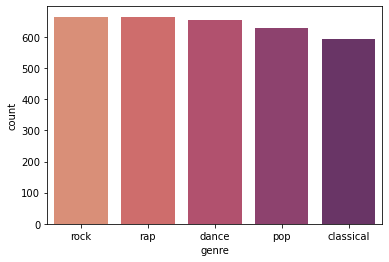

In [15]:
sns.countplot(data=dataset, x="genre", palette='flare', order = dataset['genre'].value_counts().index)

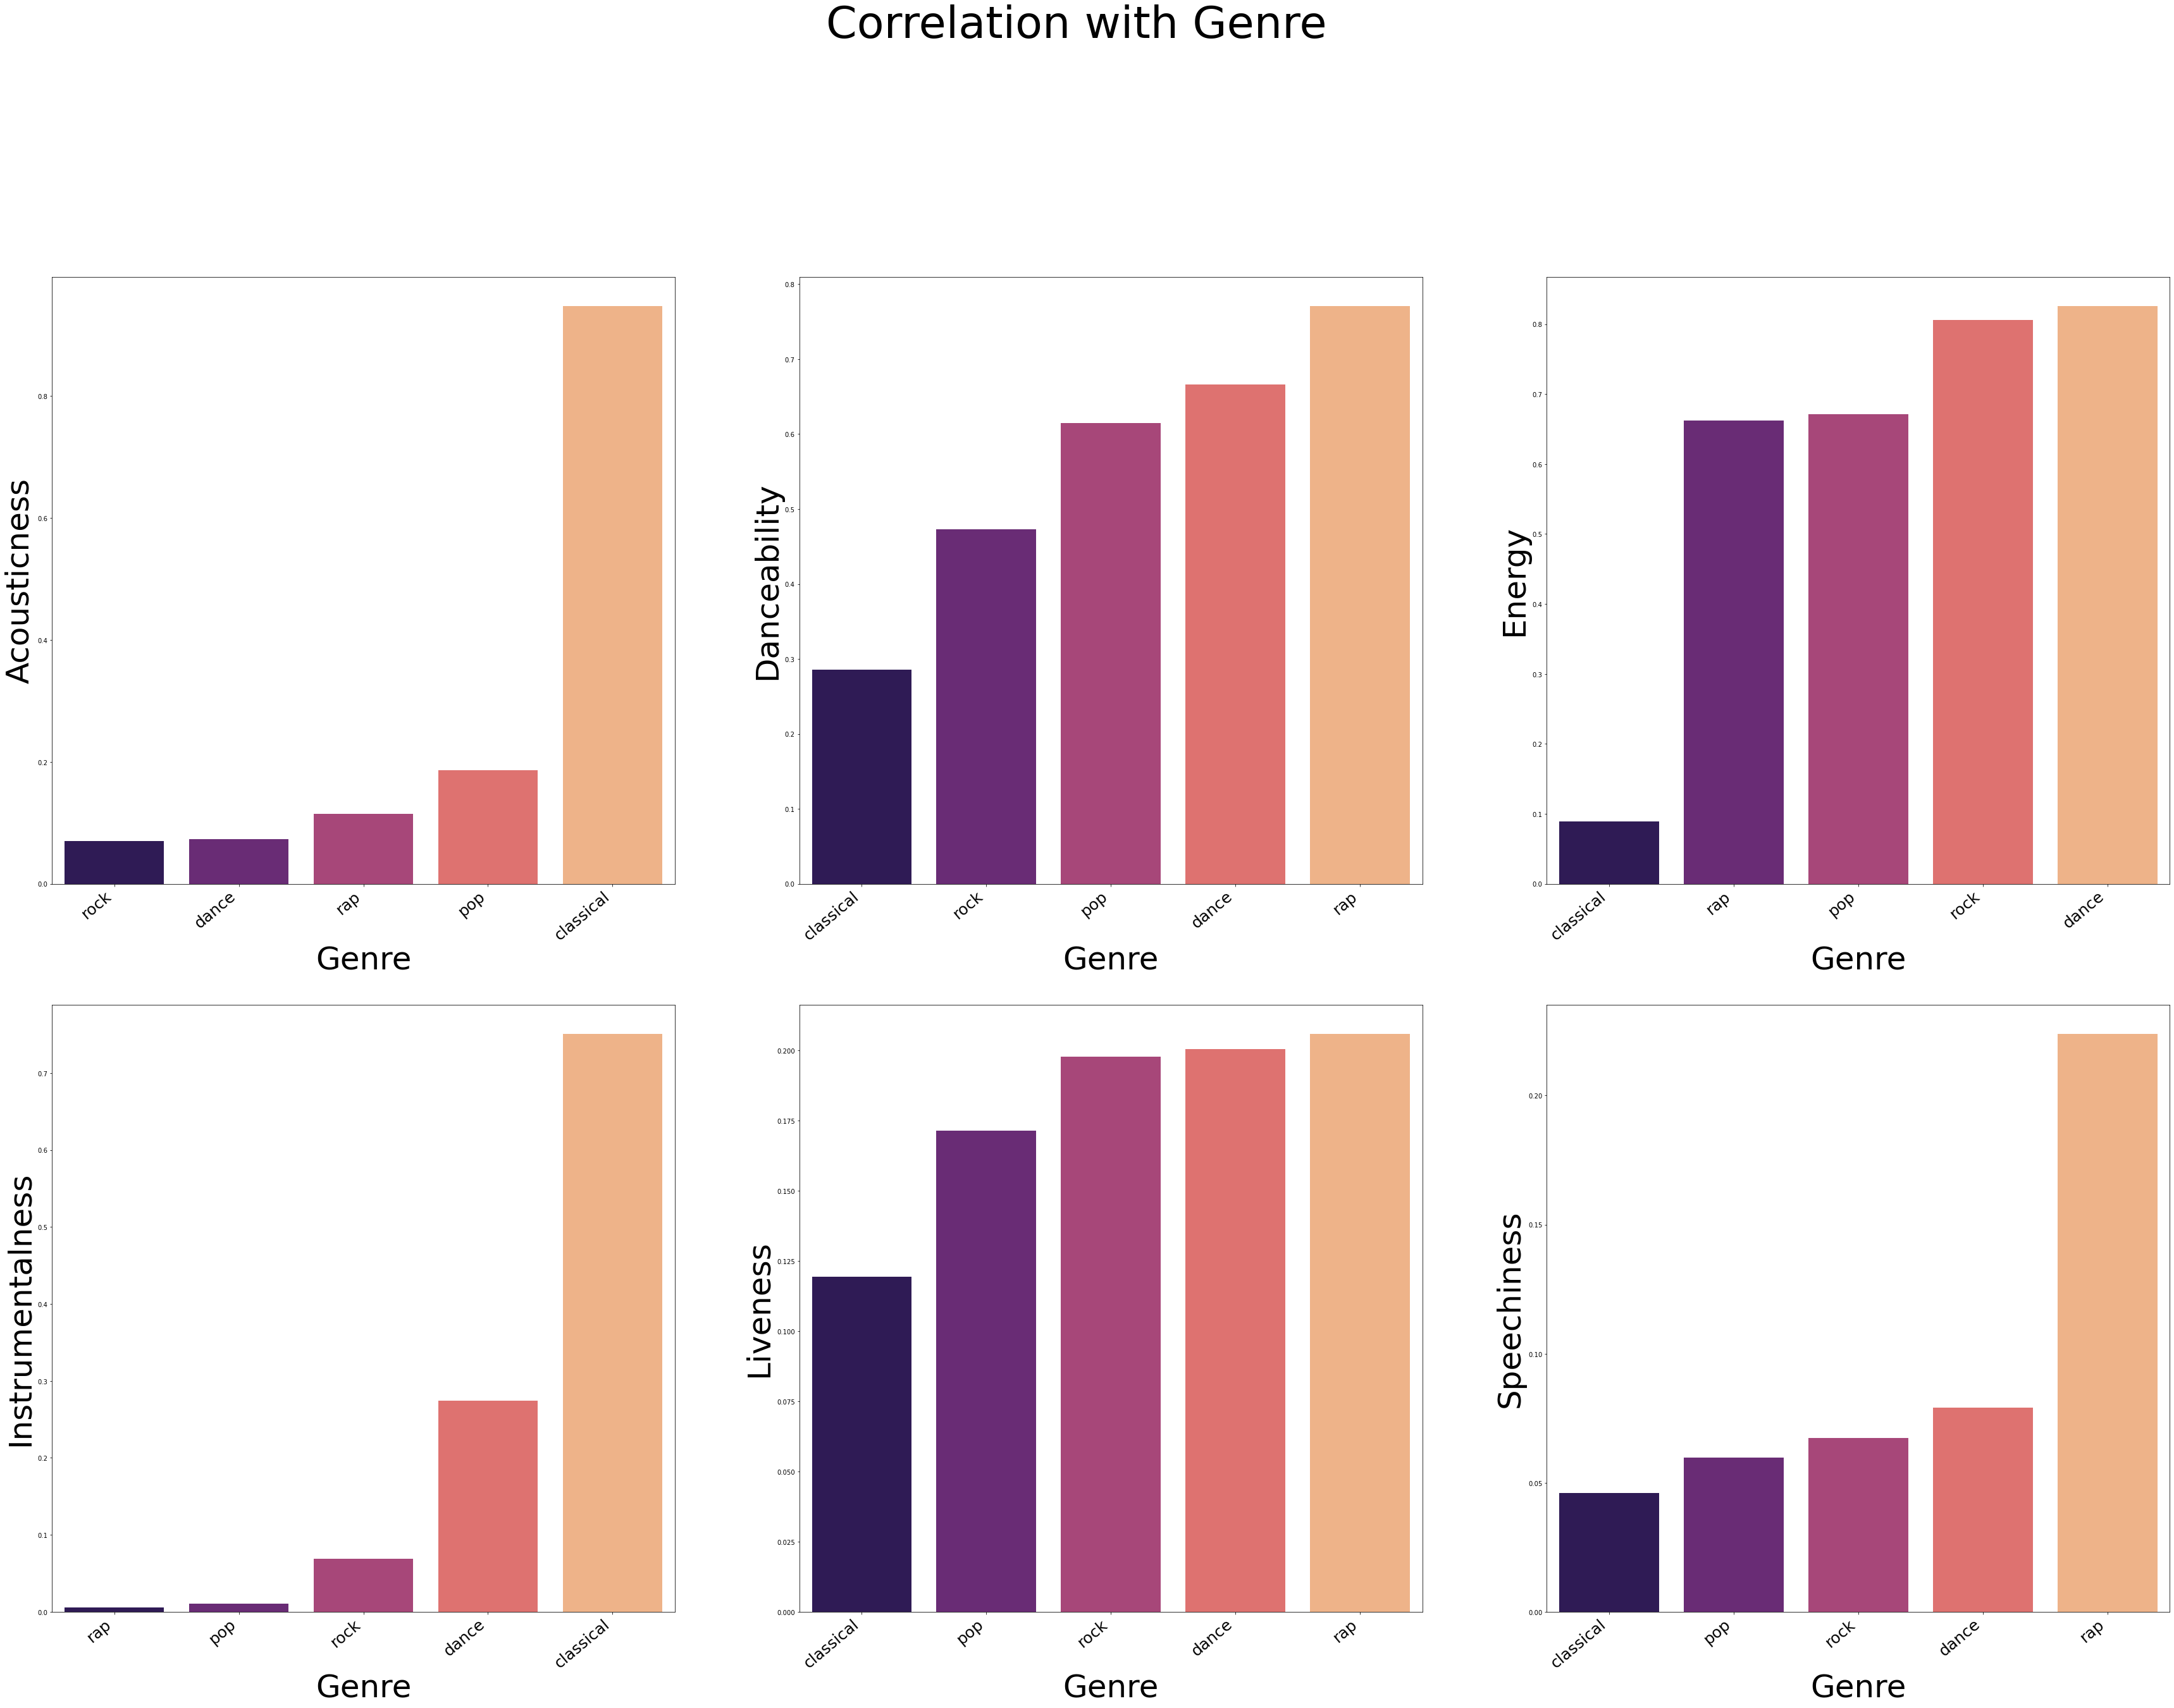

In [16]:
plt.figure(figsize=(60,60))
i = 1

for col in ["acousticness","danceability","energy","instrumentalness","liveness","speechiness"]:
    if i<=7:
        ax = plt.subplot(3,3, i)
        genre_rank =  dataset.groupby('genre')[[col]].mean().sort_values(by=col, ascending=True).reset_index()
        sns.barplot(x='genre', y=col, data=genre_rank, palette = "magma")
        plt.xlabel('Genre', fontsize= 50)
        plt.xticks(fontsize=25, rotation=40,ha="right")
        plt.ylabel(col.capitalize(),fontsize = 50)
    i +=1
plt.suptitle("Correlation with Genre",fontsize = 70)
plt.show()

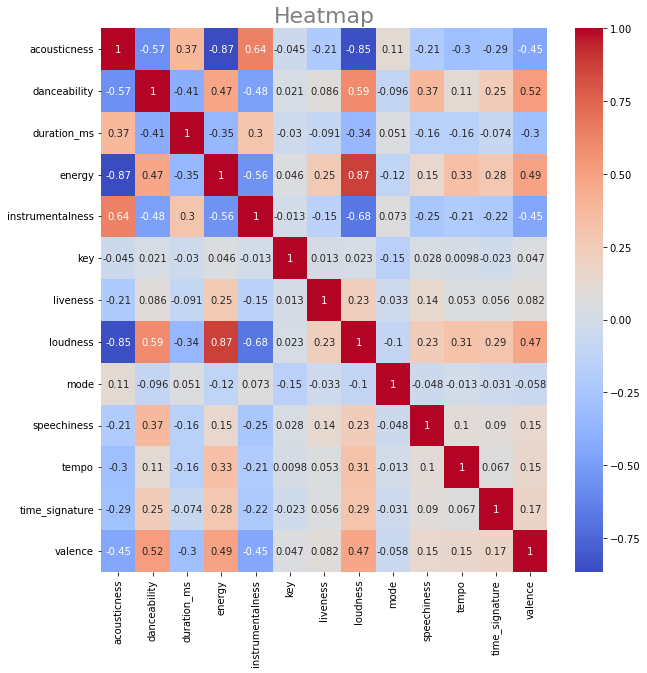

In [12]:
# Heatmap
plt.figure(figsize = (10, 10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Heatmap', fontsize=22, color='grey')
plt.show()

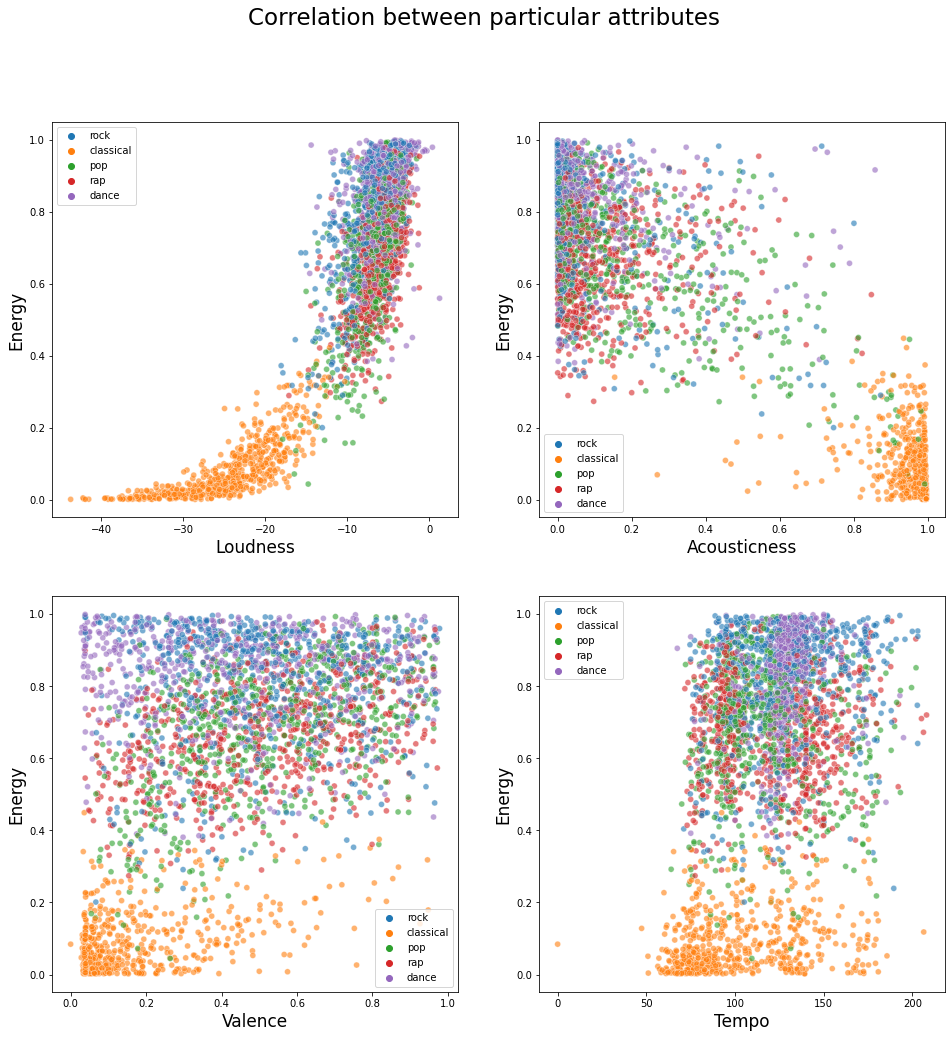

In [13]:
data_sub = dataset.sample(int(len(dataset)))

plt.figure(figsize=(16,16))

ax = plt.subplot(2,2, 1)
sns.scatterplot(x ="loudness", y="energy", data=data_sub, hue='genre', legend = "auto", alpha=0.6)
plt.xlabel("Loudness",fontsize = 17)
plt.ylabel("Energy",fontsize = 17)
plt.legend()

ax = plt.subplot(2,2,2)
sns.scatterplot(x ="acousticness", y="energy", data=data_sub, hue='genre', legend = "auto", alpha=0.6)
plt.xlabel("Acousticness",fontsize = 17)
plt.ylabel("Energy",fontsize = 17)
plt.legend()

ax = plt.subplot(2,2,3)
sns.scatterplot(x ="valence", y="energy", data=data_sub, hue='genre', legend = "auto", alpha=0.6)
plt.xlabel("Valence",fontsize = 17)
plt.ylabel("Energy",fontsize = 17)
plt.legend()

ax = plt.subplot(2,2,4)
sns.scatterplot(x ="tempo", y="energy", data=data_sub, hue='genre', legend = "auto", alpha=0.6)
plt.xlabel("Tempo",fontsize = 17)
plt.ylabel("Energy",fontsize = 17)
plt.legend()



plt.suptitle("Correlation between particular attributes",fontsize = 23)
plt.show()

In [14]:
X = dataset.drop(columns=['genre', 'loudness','time_signature'])
y = dataset['genre']
dataset.reset_index()

genre_dict = {'classical':0, 'dance':1, 'pop':2, 'rap':3, 'rock':4}

randomState = 42
testSize = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=testSize, random_state=randomState)

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

In [23]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.2, 0.4]
}
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'ccp_alpha': 0.0, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


              precision    recall  f1-score   support

   classical       0.97      1.00      0.98       113
       dance       0.74      0.69      0.71       125
         pop       0.60      0.68      0.64       123
         rap       0.84      0.90      0.87       120
        rock       0.83      0.73      0.78       161

    accuracy                           0.79       642
   macro avg       0.80      0.80      0.80       642
weighted avg       0.80      0.79      0.79       642



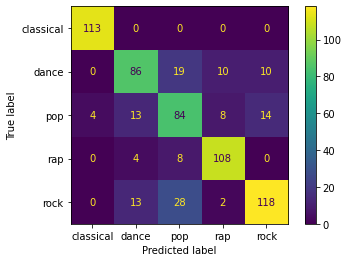

In [25]:
rfc = RandomForestClassifier(ccp_alpha=0.0, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
rfc.fit(X_train, Y_train)
Y_pred_rfc = rfc.predict(X_test)
print(classification_report(Y_test, Y_pred_rfc))

conf_matrix = confusion_matrix(Y_test, Y_pred_rfc)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = genre_dict.keys())
cm_display.plot()
plt.show()

In [26]:
param_grid = {
    'learning_rate': [0.1, 0.05],
    'n_estimators': [50, 80, 100],
    'max_depth': [3, 5],
    'min_samples_leaf': [1, 5],
    'max_features': [None, 'sqrt', 'log2']
}

gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(gbc, param_grid, cv=5)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}


              precision    recall  f1-score   support

   classical       0.97      0.99      0.98       113
       dance       0.76      0.71      0.74       125
         pop       0.61      0.71      0.66       123
         rap       0.88      0.91      0.89       120
        rock       0.85      0.75      0.80       161

    accuracy                           0.81       642
   macro avg       0.81      0.81      0.81       642
weighted avg       0.81      0.81      0.81       642



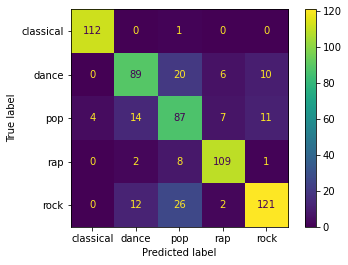

In [29]:
gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features='sqrt', min_samples_leaf=5, n_estimators=100)
gbc.fit(X_train, Y_train)
Y_pred_gbc = gbc.predict(X_test)
print(classification_report(Y_test,Y_pred_gbc))

conf_matrix = confusion_matrix(Y_test, Y_pred_gbc)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = genre_dict.keys())
cm_display.plot()
plt.show()

In [30]:
param_grid = {
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5, 7],
    'n_estimators': [30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb = XGBClassifier()
Y_train_xgb = Y_train.replace(genre_dict).astype(int)
Y_test_xgb = Y_test.replace(genre_dict).astype(int)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search_xgb.fit(X_train, Y_train_xgb)

print("Best hyperparameters: ", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       113
           1       0.77      0.74      0.75       125
           2       0.62      0.73      0.67       123
           3       0.88      0.88      0.88       120
           4       0.85      0.76      0.80       161

    accuracy                           0.81       642
   macro avg       0.82      0.82      0.82       642
weighted avg       0.82      0.81      0.81       642



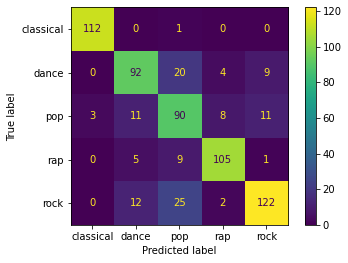

In [32]:
xgb = XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6)
Y_train_xgb = Y_train.replace(genre_dict).astype(int)
Y_test_xgb = Y_test.replace(genre_dict).astype(int)
xgb.fit(X_train, Y_train_xgb)
Y_pred_xgb = xgb.predict(X_test)
print(classification_report(Y_test_xgb.values,Y_pred_xgb))

conf_matrix = confusion_matrix(Y_test_xgb.values, Y_pred_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = genre_dict.keys())
cm_display.plot()
plt.show()

In [33]:
accuracy_model = []
accuracy_model.append(accuracy_score(Y_test.values, Y_pred_rfc))
accuracy_model.append(accuracy_score(Y_test.values, Y_pred_gbc))
accuracy_model.append(accuracy_score(Y_test_xgb.values, Y_pred_xgb))
print(accuracy_model)

[0.7928348909657321, 0.8068535825545171, 0.8115264797507789]


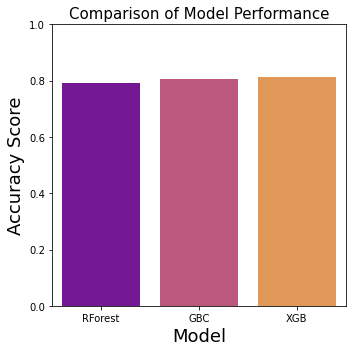

In [34]:
plt.figure(figsize=(5,5))
models = ['RForest', 'GBC', 'XGB']
sns.barplot(x=models, y=accuracy_model, palette = 'plasma')
plt.ylim (0, 1.0)
plt.title('Comparison of Model Performance', fontsize=15)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Accuracy Score', fontsize=18)
plt.tight_layout()
plt.show()

In [40]:
genre_map = {0: 'classical', 1: 'dance', 2: 'pop', 3: 'rap', 4: 'rock'}

def extract_track_features():
    genres = set()
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_ID, client_secret= client_SECRET, redirect_uri=redirect_url))
    track_id = input("Please enter spotify track id: ")
    track_features = sp.audio_features([track_id])
    print(track_features[0])
    track_info = sp.track(track_id)
    artists = track_info["artists"]
    for artist in artists:
        artist_info = sp.artist(artist["uri"])
        for genre in artist_info["genres"]:
            genres.add(genre.capitalize())

    genres = list(genres)
    audio_features = X.columns
    track_feature = [track_features[0][x] for x in audio_features]
    return track_feature, genres
track_features, genres = extract_track_features()

def return_predictions(track_features, genres, model):
    print('====================================')
    print(model.__str__().split('(')[0])
    print("Actual genres of the track: ", genres)
    audio_features = [track_features]
    audio_features = scaler.transform(audio_features)
    prediction = model.predict(audio_features)
    if type(prediction[0]) is not str:
        prediction = [genre_map[prediction[0]]]
    print("Predicted genre of the track: ", [prediction[0].capitalize()]) 
   

return_predictions(track_features, genres, rfc)
return_predictions(track_features, genres, gbc)
return_predictions(track_features, genres, xgb)

{'danceability': 0.522, 'energy': 0.558, 'key': 9, 'loudness': -9.103, 'mode': 0, 'speechiness': 0.337, 'acousticness': 0.288, 'instrumentalness': 8.67e-06, 'liveness': 0.11, 'valence': 0.693, 'tempo': 95.609, 'type': 'audio_features', 'id': '6QwJurtbHqyeVda0fhWV2B', 'uri': 'spotify:track:6QwJurtbHqyeVda0fhWV2B', 'track_href': 'https://api.spotify.com/v1/tracks/6QwJurtbHqyeVda0fhWV2B', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6QwJurtbHqyeVda0fhWV2B', 'duration_ms': 369779, 'time_signature': 4}
RandomForestClassifier
Actual genres of the track:  ['Underground hip hop', 'Hip hop', 'Rap']
Predicted genre of the track:  ['Rap']
GradientBoostingClassifier
Actual genres of the track:  ['Underground hip hop', 'Hip hop', 'Rap']
Predicted genre of the track:  ['Rap']
XGBClassifier
Actual genres of the track:  ['Underground hip hop', 'Hip hop', 'Rap']
Predicted genre of the track:  ['Rap']
